# 시설 데이터 전처리 및 개수 파악

In [91]:
# 해당 코드를 실행하기 위한 패키지 설치 목록
#!pip install pandas numpy folium geopandas scikit-learn shapely

In [196]:
import pandas as pd
import re
import geopandas as gpd
from shapely.geometry import Point

In [197]:
df = pd.read_csv('data/facilities.csv', encoding='cp949')

df = df[df["시명칭"].str.contains("서울")].reset_index(drop=True)

columns_to_keep = ['시설명', '위도', '경도', '기본정보_장소설명']
df_cleaned = df[columns_to_keep].copy()

# 표준 시설 유형 정의
def standardize_facility(info):
    if pd.isna(info):
        return '기타'

    info = info.replace(" ", "")  # 공백 제거
    count = 0
    matched = []

    if '병원' in info:
        matched.append('동물병원')
        count += 1
    if '약국' in info:
        matched.append('동물약국')
        count += 1
    if '카페' in info or '호텔' in info or '용품' in info or '미용' in info:
        matched.append('반려동물편의시설')
        count += 1

    if count == 1:
        return matched[0]
    elif count > 1:
        return '보류'
    else:
        return '기타'

# 표준화 적용
df_cleaned['표준시설유형'] = df_cleaned['기본정보_장소설명'].apply(standardize_facility)

# 결과 확인
print(df_cleaned[['기본정보_장소설명', '표준시설유형']].head(5))

  기본정보_장소설명    표준시설유형
0      동물약국      동물약국
1      애견카페  반려동물편의시설
2      동물약국      동물약국
3      동물약국      동물약국
4    일반동물병원      동물병원


In [198]:
df = df_cleaned

# 위도(LA), 경도(LO) → Point 객체로 변환
geometry = [Point(xy) for xy in zip(df['경도'], df['위도'])]
gdf_facilities = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # WGS84

# 서울시 행정동 경계 GeoJSON 불러오기
gdf_seoul = gpd.read_file("data/area.geojson")

# 좌표계 통일 (GeoJSON도 EPSG:4326이라면 생략 가능)
gdf_seoul = gdf_seoul.to_crs("EPSG:4326")


In [199]:
# 공간 조인: 시설이 어느 행정동 내에 있는지 매핑
gdf_joined = gpd.sjoin(gdf_facilities, gdf_seoul, how="inner", predicate="within")

# 필요한 컬럼 선택 (GeoJSON의 컬럼명 확인 필요)
result = gdf_joined[[
    '시설명',
    '위도', '경도', 'geometry', 'dong', 'sggnm', '표준시설유형'
]]

# 동별 표준시설유형 개수 집계
facility_counts_by_gu = result.groupby(['dong', '표준시설유형']).size().unstack(fill_value=0).reset_index()

# 결과 출력
print(facility_counts_by_gu.head(20))

표준시설유형  dong  기타  동물병원  동물약국  반려동물편의시설  보류
0       가락1동   1     0     3         1   0
1       가락2동   1     2    10         2   0
2       가락본동   0     1    10         6   0
3       가리봉동   0     0     2         1   0
4        가산동   0     1    12         7   0
5       가양1동   4     0    14        10   0
6       가양2동   1     3     2         2   0
7       가양3동   0     0     2         0   0
8        가회동   8     0     0         0   0
9       갈현1동   0     3     3         2   0
10      갈현2동   0     2     9         6   0
11       강일동   0     2     5         1   0
12      개봉1동   0     3     3         2   0
13      개봉2동   0     2     6         2   0
14      개봉3동   0     1     4         1   0
15      개포2동   2     4     2         0   0
16      개포3동   0     0     2         0   0
17      개포4동   0     5     2         1   0
18      거여1동   0     3     0         2   0
19      거여2동   0     1     4         0   0


In [200]:
df_mapping = pd.read_csv("data/dong.csv", encoding="utf-8-sig")

# 컬럼명 맞추기 위해 df_mapping 복사 및 컬럼명 통일
df_mapping_renamed = df_mapping.rename(columns={"행정동": "dong"})

# 병합 (왼쪽 기준: mapping → 모든 행정동 유지)
merged = pd.merge(df_mapping_renamed, facility_counts_by_gu, on="dong", how="left")

# 결측치 → 0으로 대체
merged.fillna(0, inplace=True)

# 숫자형으로 변환 (결측치였던 값들이 float으로 들어올 수 있음)
for col in merged.columns[2:]:
    merged[col] = pd.to_numeric(merged[col], errors="coerce").fillna(0).astype(int)

# 공원 데이터 전처리

In [201]:
#서울시 공원현황 CSV 불러오기
df_parks = pd.read_csv("data/park.csv", encoding="cp949")

# ‘소재지지번주소’가 있는 경우, 서울특별시만 필터링
if "소재지지번주소" in df_parks.columns:
    df_parks = df_parks[df_parks["소재지지번주소"]
                        .str.contains(r"^서울특별시", na=False)].reset_index(drop=True)

# 컬럼명 통일 (실제 CSV 컬럼명에 맞추어 수정)
df_parks = df_parks.rename(columns={
    "공원명":       "녹지대명",
    "공원면적":         "녹지대면적",
})

In [202]:
# 숫자형으로 변환 (문자열→NaN), 면적도 숫자로
df_parks["경도"]       = pd.to_numeric(df_parks["경도"], errors="coerce")
df_parks["위도"]       = pd.to_numeric(df_parks["위도"], errors="coerce")
df_parks["녹지대면적"] = pd.to_numeric(df_parks["녹지대면적"], errors="coerce")

# 5. 좌표·이름·면적 누락 행 제거
df_parks = (
    df_parks
    .dropna(subset=["경도", "위도", "녹지대명", "녹지대면적"])
    .reset_index(drop=True)
)


In [203]:
# Point geometry 생성
geometry  = [Point(xy) for xy in zip(df_parks["경도"], df_parks["위도"])]
gdf_parks = gpd.GeoDataFrame(df_parks, geometry=geometry, crs="EPSG:4326")

# 행정동 경계 GeoJSON 불러오기
gdf_seoul = gpd.read_file("data/area.geojson", encoding="utf-8")

# CRS 통일
if gdf_parks.crs != gdf_seoul.crs:
    gdf_parks = gdf_parks.to_crs(gdf_seoul.crs)

In [204]:
# 9. 공간 조인: 공원이 속한 행정동 매핑
gdf_joined = gpd.sjoin(
    gdf_parks,
    gdf_seoul[["geometry", "dong"]],
    how="left",
    predicate="within"
)
gdf_joined = gdf_joined.drop(columns=["index_right"], errors="ignore")

# 10. DataFrame으로 변환 후 필요한 컬럼만 선택
df_result = pd.DataFrame(gdf_joined.drop(columns="geometry"))
selected  = df_result[["녹지대명", "녹지대면적", "dong"]]

# 11. ‘녹지대명’ 중복 제거 (첫 출현 유지)
selected = selected.drop_duplicates(subset=["녹지대명"], keep="first").reset_index(drop=True)

# 12. dong별로 공원명 쉼표 연결, 면적 합산
aggregated = selected.groupby("dong", as_index=False).agg({
    "녹지대명":   lambda names: ", ".join(names.astype(str)),
    "녹지대면적": "sum"
})

# 13. 결과 확인
print(aggregated.head())

   dong                                               녹지대명     녹지대면적
0  가락1동                                         가락1(시영아파트)   19159.2
1  가락2동                          개롱, 샛팽이, 안산골, 투구봉, 새말, 대건   29046.6
2  가락본동                웃말, 가락, 건너말, 팔각정, 방죽, 봉우리, 비석거리, 훙이   57683.5
3   가산동                                        조마, 무아래, 골말    3650.6
4  가양1동  푸르미, 마곡지구4호, 탑산(가양동), 놋다리, 똘고랑, 선두암, 한다리, 가로공원...  739115.9


In [205]:
# 2. 'dong' 컬럼을 기준으로 병합 (왼쪽 기준: selected_green)
combined = pd.merge(
    aggregated,
    merged,
    on="dong",
    how="outer"
)

# 3. 병합 후 누락된 값( NaN )을 0으로 채우기
combined.fillna(0, inplace=True)

# 4. 숫자형 컬럼들(int 타입)로 변환
#    'dong', '녹지대명', '구명' 같은 문자열 컬럼은 제외하고 변환합니다.
for col in combined.columns:
    if col not in ["dong", '구']: # 필요하면 "녹지대명"도 제외할 수 있음
        combined[col] = (
            pd.to_numeric(combined[col], errors="coerce")
              .fillna(0)
              .astype(int)
        )

combined.head(10)

dong  녹지대명   녹지대면적    구  기타  동물병원  동물약국  반려동물편의시설  보류
0  가락1동     0   19159  송파구   1     0     3         1   0
1  가락2동     0   29046  송파구   1     2    10         2   0
2  가락본동     0   57683  송파구   0     1    10         6   0
3  가리봉동     0       0  구로구   0     0     2         1   0
4   가산동     0    3650  금천구   0     1    12         7   0
5  가양1동     0  739115  강서구   4     0    14        10   0
6  가양2동     0   32917  강서구   1     3     2         2   0
7  가양3동     0   23615  강서구   0     0     2         0   0
8   가회동     0   10004  종로구   8     0     0         0   0
9  갈현1동     0    4365  은평구   0     3     3         2   0

# 면적데이터 추가

In [206]:
area = pd.read_csv("data/area.csv", encoding="utf-8-sig")
area = area.drop(columns=["구"]) 
area["면적(m2)"] = area["면적"] * 1000000

# 2. ‘dong’을 기준으로 결합
merged_area = pd.merge(
    combined,
    area,
    on="dong",
    how="left"
)

# 3. 결측치(NA) → 0으로 채우기
merged_area.fillna(0, inplace=True)

merged_area.drop(columns=["녹지대명", "기타", "보류"], inplace=True)
# 5. 결과 확인 (상위 5개)
merged_area.head(5)

dong  녹지대면적    구  동물병원  동물약국  반려동물편의시설    면적     면적(m2)
0  가락1동  19159  송파구     0     3         1  1.34  1340000.0
1  가락2동  29046  송파구     2    10         2  0.96   960000.0
2  가락본동  57683  송파구     1    10         6  1.13  1130000.0
3  가리봉동      0  구로구     0     2         1  0.40   400000.0
4   가산동   3650  금천구     1    12         7  2.52  2520000.0

# 반려동물 수 전처리

In [207]:
# 2. 구별 반려동물 수 파일 불러오기
merged_pet_gu = pd.read_csv("data/pet_count.csv", encoding="cp949")  
#   → 컬럼: ['구', '반려동물수']

# 3. 구별 총면적(m2) 계산 및 비율 컬럼 추가
merged_area["구_총면적(m2)"] = merged_area.groupby("구")["면적(m2)"].transform("sum")
merged_area["구면적(m2)대비비율"] = (merged_area["면적(m2)"] / merged_area["구_총면적(m2)"]) * 100
merged_area = merged_area.drop(columns=["구_총면적(m2)"])

# 4. 면적(m2) 대비 비율이 담긴 merged_area와 반려동물 수 merged_pet_gu를 '구' 기준으로 병합
merged_merged = pd.merge(
    merged_area,
    merged_pet_gu,
    on="구",
    how="left"
)

# 5. '구면적(m2)대비비율'을 활용해 동별 반려동물 수 비례 배분
merged_merged["동별_반려동물수"] = (merged_merged["반려동물수"] * merged_merged["구면적(m2)대비비율"]) / 100

# 6. 동별 반려동물 수를 정수형으로 변환
merged_merged["동별_반려동물수"] = merged_merged["동별_반려동물수"].astype(int)

# 7. 필요한 컬럼만 남겨서 결과 확인
result = merged_merged[["구", "dong", "면적(m2)", "구면적(m2)대비비율","동별_반려동물수"]]
print(result.head())

     구  dong     면적(m2)  구면적(m2)대비비율  동별_반려동물수
0  송파구  가락1동  1340000.0     3.955136      1503
1  송파구  가락2동   960000.0     2.833530      1076
2  송파구  가락본동  1130000.0     3.335301      1267
3  구로구  가리봉동   400000.0     1.988072       436
4  금천구   가산동  2520000.0    19.354839      2830


# 인구 데이터 추가

In [208]:
# 원본 CSV 불러오기 (실제 경로·인코딩에 맞게 수정)
pop = pd.read_csv("data/pop.csv", encoding="cp949")

# 컬럼명 변경
pop = pop.rename(columns={
    "행정구역": "dong",
    "2025년05월_총인구수": "인구수",
    "2025년05월_세대수": "세대수"
})

pop.drop(columns=["2025년05월_세대당 인구", "2025년05월_남자 인구수", "2025년05월_여자 인구수", "2025년05월_남여 비율"], inplace=True)
pop

dong        인구수        세대수
0              서울특별시  (1100000000)  9,328,042  4,498,871
1           서울특별시 종로구 (1111000000)    138,049     72,434
2      서울특별시 종로구 청운효자동(1111051500)     10,978      4,919
3        서울특별시 종로구 사직동(1111053000)      8,906      4,557
4        서울특별시 종로구 삼청동(1111054000)      2,157      1,083
...                            ...        ...        ...
3908  제주특별자치도 서귀포시 서홍동(5013058000)     11,043      4,627
3909  제주특별자치도 서귀포시 대륜동(5013059000)     14,969      6,927
3910  제주특별자치도 서귀포시 대천동(5013060000)     13,719      6,549
3911  제주특별자치도 서귀포시 중문동(5013061000)     12,081      5,998
3912  제주특별자치도 서귀포시 예래동(5013062000)      3,809      2,018

[3913 rows x 3 columns]

In [209]:
# “dong”에 “서울” 포함된 행만 남기기
pop = pop[pop["dong"].str.contains("서울")].reset_index(drop=True)

# 괄호가 있는 행(dong 문자열에 '(' 포함) 제거
pop["dong"] = pop["dong"].str.replace(r"\s*\(.*?\)", "", regex=True).str.strip()
# 'dong' 컬럼에서 '제'가 숫자+동 앞에만 붙어 있을 때만 제거하기
pop["dong"] = pop["dong"].str.replace(r"제(?=\d+동)", "", regex=True)

# “서울특별시 ○○구 ○○동” 형식에서 시·구·동을 추출
#    - 정규표현식으로 정확히 3개 그룹(시, 구, 동)만 뽑아냅니다.
#    - 예: "서울특별시 종로구 사직동" → 시="서울특별시", 구="종로구", 동="사직동"
pattern = r"^(서울특별시)\s+([^ ]+구)\s+(.+동)$"
extracted = pop["dong"].str.extract(pattern)

# 추출 결과 컬럼명이 0,1,2 → 각각 “시”, “구”, “dong”으로 바꿔서 데이터프레임에 붙이기
extracted.columns = ["시", "구", "dong_small"]
pop = pd.concat([pop, extracted], axis=1)

# 5-2. 정규표현식에 매칭되지 않은(=NaN이 생긴) 행들은 제거
pop = pop[pop["dong_small"].notna()].reset_index(drop=True)


In [210]:
# 원래의 'dong' 컬럼은 더 이상 필요 없으니 제거한 뒤, 'dong_small'을 'dong'으로 이름 변경
pop = pop.drop(columns=["dong", "시", "구"])
pop = pop.rename(columns={"dong_small": "dong"})

for col in ["인구수", "세대수"]:
    pop[col] = (
        pop[col]
        .astype(str)
        .str.replace(",", "", regex=False)
    )
    pop[col] = pd.to_numeric(pop[col], errors="coerce").fillna(0).astype(int)

# 'dong' 컬럼에 있는 모든 마침표(.)를 중간점(·)으로 교체하기
pop["dong"] = pop["dong"].str.replace(".", "·", regex=False)

merged_pop = pd.merge(
    merged_merged,
    pop,
    on="dong",
    how="left"
)

merged_pop.head(10)

dong   녹지대면적    구  동물병원  동물약국  반려동물편의시설    면적     면적(m2)  구면적(m2)대비비율  \
0  가락1동   19159  송파구     0     3         1  1.34  1340000.0     3.955136   
1  가락2동   29046  송파구     2    10         2  0.96   960000.0     2.833530   
2  가락본동   57683  송파구     1    10         6  1.13  1130000.0     3.335301   
3  가리봉동       0  구로구     0     2         1  0.40   400000.0     1.988072   
4   가산동    3650  금천구     1    12         7  2.52  2520000.0    19.354839   
5  가양1동  739115  강서구     0    14        10  4.70  4700000.0    11.341699   
6  가양2동   32917  강서구     3     2         2  1.00  1000000.0     2.413127   
7  가양3동   23615  강서구     0     2         0  0.50   500000.0     1.206564   
8   가회동   10004  종로구     0     0         0  0.54   540000.0     2.258469   
9  갈현1동    4365  은평구     3     3         2  0.97   970000.0     3.265993   

   반려동물수  동별_반려동물수      인구수      세대수  
0  38005      1503  26974.0   9650.0  
1  38005      1076  30506.0  12369.0  
2  38005      1267  24570.0  11576.0  
3  21967       436   8724.0   6051.0  
4  14624      2830  25148.0  18607.0  
5  37800      4287  33548.0  21055.0  
6  37800       912  13064.0   7905.0  
7  37800       456  13571.0   7591.0  
8  10698       241   3711.0   1851.0  
9  31725      1036  14129.0   7211.0

##  PCA (Principal Component Analysis) 사용 목적 정리

| 목적                           | 설명                                                                 |
|------------------------------|----------------------------------------------------------------------|
| 차원 축소 (Dimensionality Reduction) | 고차원 데이터를 저차원으로 변환하여 시각화, 계산 효율성 향상 등에 활용 |
|  데이터 시각화              | 2D 또는 3D로 축소해 데이터의 분포와 패턴을 직관적으로 파악 가능        |
| 잡음 제거 (Noise Reduction) | 주요 정보만 보존하고 노이즈 성분(분산이 작은 축)을 제거하여 성능 향상   |
|  과적합 방지                | 불필요한 특성 제거를 통해 모델 복잡도 감소 및 일반화 성능 향상         |
|  계산 속도 향상             | 모델 입력 차원을 줄임으로써 학습 및 추론 속도 개선                     |
| 상관관계 제거              | 상관된 변수들을 직교(orthogonal)한 성분으로 변환하여 독립성 확보       |


| 예상질문                         | 답변                                                                 |
|------------------------------|----------------------------------------------------------------------|
| 히트맵 수치가 1로 갈수록 좋나? | X 좋고 나쁨이 아니라 영향력과 방향을 나타냄                      |
| 절댓값이 클수록?              | O 주성분에 영향이 크다는 뜻                                           |
| 부호(+, -) 의미는?            | O 방향성: 같은 방향 or 반대 방향                                     |
| 점수화 가능?                  | O 가능. PC1의 score를 지표처럼 활용 가능                              |


In [211]:
#히트맵 만들기 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [221]:
# 한글 → 영어 컬럼 매핑
col_map = {
    'dong': 'dong',
    '녹지대면적': 'green_area',
    '구': 'district',
    '동물병원': 'animal_hospitals',
    '동물약국': 'animal_pharmacies',
    '반려동물편의시설': 'pet_facilities',
    '면적': 'area_ratio',
    '면적(m2)': 'area_m2',
    '구면적(m2)대비비율': 'district_area_ratio',
    '반려동물수': 'total_pets',
    '동별_반려동물수': 'pets_per_dong',
    '인구수': 'population',
    '세대수': 'households'
}

merged_pop = merged_pop.rename(columns=col_map)


In [222]:
# 분석에 사용할 피처 목록(영어)
features = [
    'green_area', 'animal_hospitals', 'animal_pharmacies', 'pet_facilities',
    'area_ratio', 'area_m2', 'district_area_ratio',
    'total_pets', 'pets_per_dong', 'population', 'households'
]

In [223]:
#결측값 처리
X = merged_pop[features].fillna(merged_pop[features].mean())

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [224]:
# PCA
pca = PCA(n_components=len(features))
X_pca = pca.fit_transform(X_scaled)

# PCA 구성요소 DataFrame
pca_df = pd.DataFrame(
    pca.components_,
    columns=features,
    index=[f'PC{i+1}' for i in range(len(features))]
)
pca_df

green_area  animal_hospitals  animal_pharmacies  pet_facilities  \
PC1   1.342849e-01      1.787512e-01       1.718514e-01    1.375150e-01   
PC2  -1.617939e-01      3.912013e-01       3.761978e-01    3.799598e-01   
PC3  -5.484031e-03      2.193862e-01       4.312947e-01    5.109780e-01   
PC4   9.055189e-01     -5.167108e-02       3.834112e-02    8.474766e-02   
PC5  -3.466202e-01     -8.660256e-02       6.171808e-02   -9.756318e-02   
PC6   5.243331e-02      8.473494e-01      -4.390391e-01   -1.828497e-01   
PC7  -7.806601e-02     -1.707842e-01      -6.630362e-01    7.131549e-01   
PC8  -7.861696e-02     -2.366438e-02       4.181916e-02    3.342491e-02   
PC9   2.501997e-02     -9.426950e-02       5.508790e-02    1.255757e-01   
PC10 -9.357218e-05     -9.716091e-03       2.218504e-02    3.227238e-03   
PC11  9.421959e-17     -3.750141e-16      -8.517528e-17    5.130901e-16   

      area_ratio   area_m2  district_area_ratio    total_pets  pets_per_dong  \
PC1     0.430220  0.430220         3.963464e-01  1.363284e-01   4.423397e-01   
PC2    -0.225875 -0.225875        -2.868306e-01  3.028502e-01  -1.941172e-01   
PC3     0.074080  0.074080         1.103427e-01 -2.809487e-01   5.290808e-04   
PC4    -0.080738 -0.080738        -1.152769e-01  3.528860e-01  -2.652438e-02   
PC5     0.168787  0.168787        -1.610555e-01  7.709626e-01   9.226597e-02   
PC6     0.012759  0.012759        -1.926382e-02  9.631529e-03   1.696943e-02   
PC7     0.015526  0.015526        -1.479328e-04  1.006914e-01   3.946539e-02   
PC8    -0.439833 -0.439833         5.588460e-01  1.519234e-01   3.730960e-01   
PC9     0.146294  0.146294        -2.233062e-01 -1.550801e-01  -1.282475e-01   
PC10   -0.090207 -0.090207        -5.888030e-01 -1.857154e-01   7.745604e-01   
PC11    0.707107 -0.707107        -4.698879e-16 -5.380481e-17  -2.931754e-15   

        population    households  
PC1   2.894229e-01  2.762037e-01  
PC2   3.123617e-01  3.515820e-01  
PC3  -5.050837e-01 -3.841001e-01  
PC4  -8.028682e-02 -1.034854e-01  
PC5  -2.309990e-01 -3.461982e-01  
PC6  -2.594712e-02 -2.265165e-01  
PC7  -1.778901e-02  6.353473e-02  
PC8   1.972033e-01 -3.000130e-01  
PC9   6.797299e-01 -6.135827e-01  
PC10 -4.285939e-02  1.297841e-02  
PC11  1.010752e-15 -7.465413e-16

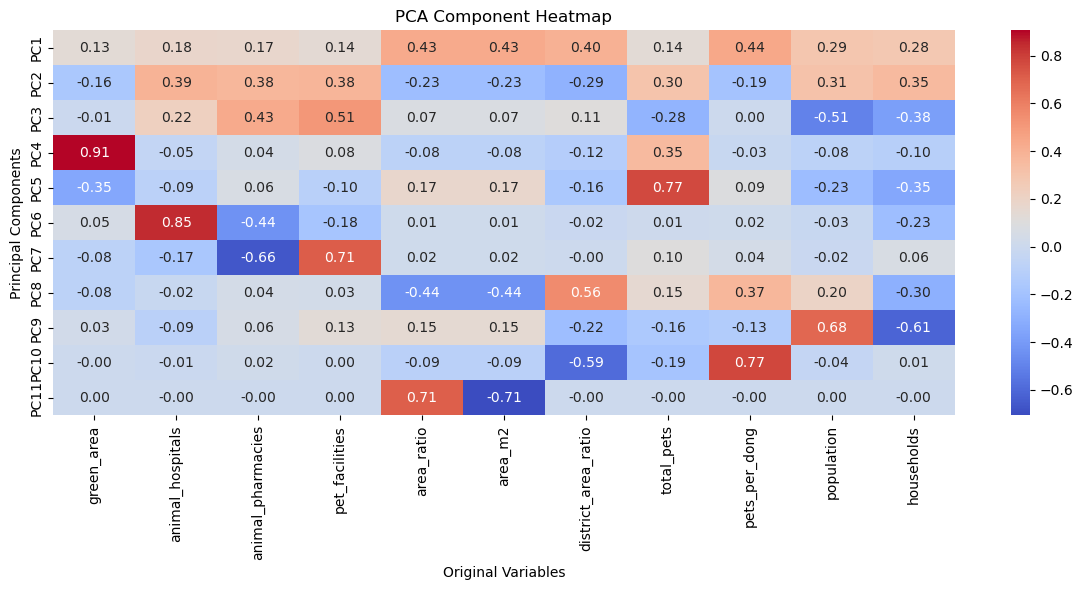

In [225]:
# 히트맵 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(pca_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA Component Heatmap')       
plt.xlabel('Original Variables')         
plt.ylabel('Principal Components')        
plt.tight_layout()
plt.show()

# 펫프렌들리 지수 산출(PCA 방식)

In [219]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [226]:
#  시설 총합 (동물병원 + 동물약국 + 반려동물편의시설)
merged_pop["total_facilities"] = (
    merged_pop["animal_hospitals"] + 
    merged_pop["animal_pharmacies"] + 
    merged_pop["pet_facilities"]
)
# 반려동물 1마리당 시설 수
merged_pop["facilities_per_pet"] = (
    merged_pop["total_facilities"] / merged_pop["pets_per_dong"]
)

# 반려동물 1마리당 녹지대 면적
merged_pop["green_area_per_pet"] = (
    merged_pop["green_area"] / merged_pop["pets_per_dong"]
)

# 반려동물 1마리당 동 면적
merged_pop["area_m2_per_pet"] = (
    merged_pop["area_m2"] / merged_pop["pets_per_dong"]
)


In [227]:
# 각 지표를 Min-Max 정규화 (0~1 사이)
#    정규화 함수 정의
def min_max_norm(series):
    return (series - series.min()) / (series.max() - series.min())

# 정규화된 컬럼 생성
merged_pop["total_facilities_norm"] = min_max_norm(merged_pop["total_facilities"])

# 반려동물 1마리당 시설 수 (높을수록 좋음)
merged_pop["facilities_per_pet_norm"] = min_max_norm(merged_pop["facilities_per_pet"])

#반려동물 1마리당 녹지대 면적 (높을수록 좋음)
merged_pop["green_area_per_pet_norm"] = min_max_norm(merged_pop["green_area_per_pet"])

# 반려동물 1마리당 동 면적 (높을수록 좋음)
merged_pop["area_m2_per_pet_norm"] = min_max_norm(merged_pop["area_m2_per_pet"])

merged_pop

dong  green_area district  animal_hospitals  animal_pharmacies  \
0    가락1동       19159      송파구                 0                  3   
1    가락2동       29046      송파구                 2                 10   
2    가락본동       57683      송파구                 1                 10   
3    가리봉동           0      구로구                 0                  2   
4     가산동        3650      금천구                 1                 12   
..    ...         ...      ...               ...                ...   
427   효창동      174662      용산구                 2                  0   
428   후암동        2522      용산구                 2                  0   
429  휘경1동           0     동대문구                 0                  2   
430  휘경2동        5993     동대문구                 2                  0   
431   흑석동      388959      동작구                 2                  4   

     pet_facilities  area_ratio    area_m2  district_area_ratio  total_pets  \
0                 1        1.34  1340000.0             3.955136       38005   
1                 2        0.96   960000.0             2.833530       38005   
2                 6        1.13  1130000.0             3.335301       38005   
3                 1        0.40   400000.0             1.988072       21967   
4                 7        2.52  2520000.0            19.354839       14624   
..              ...         ...        ...                  ...         ...   
427               0        0.44   440000.0             2.011888       19468   
428               2        0.86   860000.0             3.932327       19468   
429               3        0.63   630000.0             4.433498       21151   
430               0        1.05  1050000.0             7.389163       21151   
431               1        1.68  1680000.0            10.275229       21093   

     ...  population  households  total_facilities  facilities_per_pet  \
0    ...     26974.0      9650.0                 4            0.002661   
1    ...     30506.0     12369.0                14            0.013011   
2    ...     24570.0     11576.0                17            0.013418   
3    ...      8724.0      6051.0                 3            0.006881   
4    ...     25148.0     18607.0                20            0.007067   
..   ...         ...         ...               ...                 ...   
427  ...     10486.0      4711.0                 2            0.005115   
428  ...     15742.0      8275.0                 4            0.005229   
429  ...     13034.0      7441.0                 5            0.005336   
430  ...     24050.0     12801.0                 2            0.001280   
431  ...     29967.0     12984.0                 7            0.003230   

     green_area_per_pet  area_m2_per_pet  total_facilities_norm  \
0             12.747172       891.550233                   0.08   
1             26.994424       892.193309                   0.28   
2             45.527230       891.870560                   0.34   
3              0.000000       917.431193                   0.06   
4              1.289753       890.459364                   0.40   
..                  ...              ...                    ...   
427          446.705882      1125.319693                   0.04   
428            3.296732      1124.183007                   0.08   
429            0.000000       672.358591                   0.10   
430            3.836748       672.215109                   0.04   
431          179.491924       775.265344                   0.14   

     facilities_per_pet_norm  green_area_per_pet_norm  area_m2_per_pet_norm  
0                   0.049152                 0.003504              0.151330  
1                   0.240300                 0.007421              0.151730  
2                   0.247805                 0.012516              0.151529  
3                   0.127079                 0.000000              0.167440  
4                   0.130521                 0.000355              0.150651  
..                       ...             

In [228]:
# PCA 입력용 데이터 선택
features = [
    "total_facilities_norm",
    "facilities_per_pet_norm",
    "green_area_per_pet_norm",
    "area_m2_per_pet_norm"
]

df_pca = merged_pop.dropna(subset=features)[features]
df_pca

total_facilities_norm  facilities_per_pet_norm  green_area_per_pet_norm  \
0                     0.08                 0.049152                 0.003504   
1                     0.28                 0.240300                 0.007421   
2                     0.34                 0.247805                 0.012516   
3                     0.06                 0.127079                 0.000000   
4                     0.40                 0.130521                 0.000355   
..                     ...                      ...                      ...   
427                   0.04                 0.094469                 0.122809   
428                   0.08                 0.096569                 0.000906   
429                   0.10                 0.098553                 0.000000   
430                   0.04                 0.023648                 0.001055   
431                   0.14                 0.059659                 0.049346   

     area_m2_per_pet_norm  
0                0.151330  
1                0.151730  
2                0.151529  
3                0.167440  
4                0.150651  
..                    ...  
427              0.296848  
428              0.296141  
429              0.014885  
430              0.014796  
431              0.078944  

[432 rows x 4 columns]

In [229]:
# 표준화 (평균0, 분산1)
scaler = StandardScaler()
X_std = scaler.fit_transform(df_pca)

각 컬럼 평균:
 total_facilities_norm     -4.523131e-17
facilities_per_pet_norm    9.457455e-17
green_area_per_pet_norm    2.055969e-17
area_m2_per_pet_norm      -2.055969e-17
dtype: float64


각 컬럼 표준편차:
 total_facilities_norm      1.001159
facilities_per_pet_norm    1.001159
green_area_per_pet_norm    1.001159
area_m2_per_pet_norm       1.001159
dtype: float64


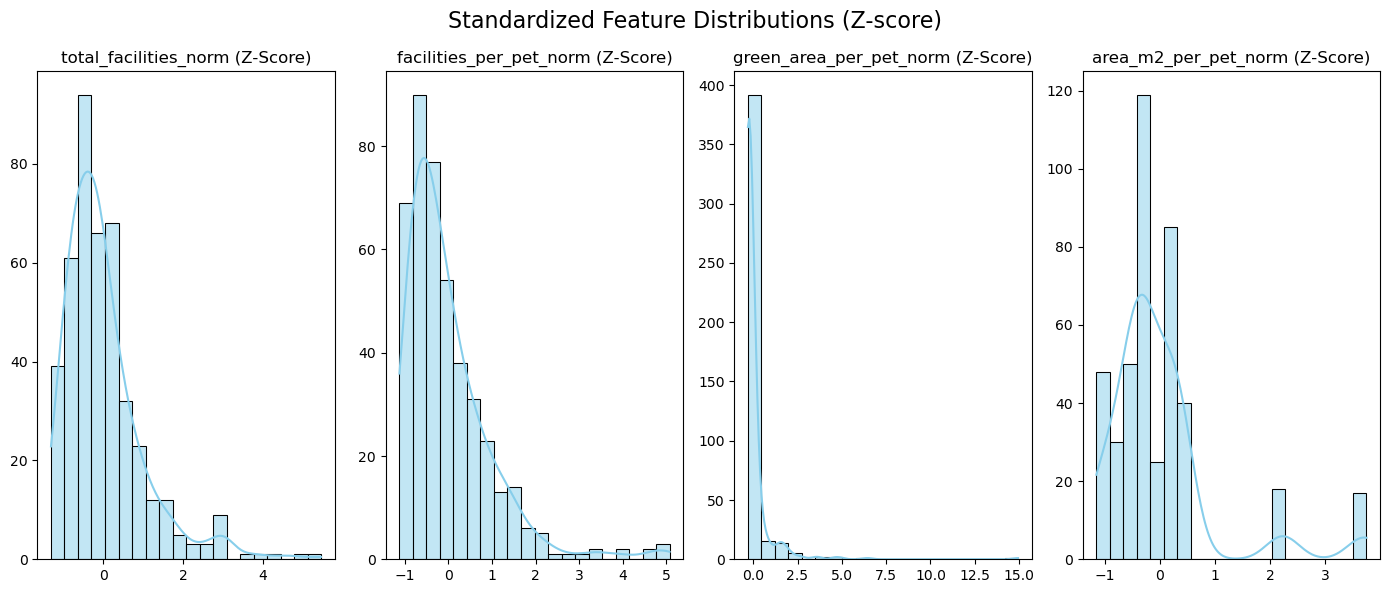

In [230]:
##표준화 결과 시각화 
df_std = pd.DataFrame(X_std, columns=df_pca.columns)

# 평균과 표준편차 확인
print("각 컬럼 평균:\n", df_std.mean())
print("\n")
print("각 컬럼 표준편차:\n", df_std.std())

# 시각화
plt.figure(figsize=(14, 6))

# 히스토그램 + KDE
for i, col in enumerate(df_std.columns):
    plt.subplot(1, len(df_std.columns), i+1)
    sns.histplot(df_std[col], kde=True, bins=20, color="skyblue")
    plt.title(f"{col} (Z-Score)")
    plt.xlabel("")
    plt.ylabel("")

plt.suptitle("Standardized Feature Distributions (Z-score)", fontsize=16)
plt.tight_layout()
plt.show()

In [231]:
# PCA(n_components=3) 적용하여 PC1, PC2, PC3 추출
pca = PCA(n_components=3, random_state=42)
pcs = pca.fit_transform(X_std)    # shape = (n_samples, 3)
evr = pca.explained_variance_ratio_

print("▶ 주성분별 설명분산비율:", np.round(evr, 4))

▶ 주성분별 설명분산비율: [0.4102 0.286  0.2224]


In [232]:
# loadings 방향 보정 (각 PC마다 음수가 더 많으면 뒤집기)
loadings = pca.components_        # shape = (3, n_features)
for i in range(3):
    if (loadings[i] < 0).sum() > (loadings[i] > 0).sum():
        pcs[:, i] = -pcs[:, i]

In [233]:
# 각 PC를 0~1로 Min–Max 스케일링
mins = pcs.min(axis=0)
maxs = pcs.max(axis=0)
pcs_norm = (pcs - mins) / (maxs - mins)

# merged_pop에 PC1~PC3 컬럼 추가
for i in range(3):
    merged_pop.loc[df_pca.index, f"PC{i+1}"] = pcs_norm[:, i]

In [234]:
# PC1~3을 분산비율 가중합하여 단일지수로 결합
#    weight_sum = evr.sum()  → 1.0이 될 것이므로 곧바로 evr를 가중치로 사용
merged_pop.loc[df_pca.index, "petfriendly_num"] = (
      evr[0] * pcs_norm[:, 0]
    + evr[1] * pcs_norm[:, 1]
    + evr[2] * pcs_norm[:, 2]
)

# 결과 확인
print(merged_pop[["dong", "PC1", "PC2", "PC3", "petfriendly_num"]].head())


   dong       PC1       PC2       PC3  petfriendly_num
0  가락1동  0.079948  0.110865  0.184561         0.105551
1  가락2동  0.313773  0.092683  0.215383         0.203124
2  가락본동  0.353716  0.088309  0.228153         0.221098
3  가리봉동  0.116970  0.119082  0.175184         0.121004
4   가산동  0.321987  0.063689  0.226843         0.200749


# 분위수를 활용한 창업 추천 로직

In [235]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [236]:
# 부족항목 계산을 위한 기준값(녹지·시설 비율 하위 20%) 구하기
green_thresh_norm    = merged_pop["green_area_per_pet_norm"].quantile(0.2)
facility_thresh_norm = merged_pop["facilities_per_pet_norm"].quantile(0.2)

In [237]:
# 부족 항목 판정 함수 ― 영어 컬럼명 사용, 결과 컬럼은 'need_items'
def check_need(row):
    need = []
    if row["green_area_per_pet_norm"] < green_thresh_norm:
        need.append("공원 부족")
    if row["facilities_per_pet_norm"] < facility_thresh_norm:
        need.append("시설 부족")
    return "-" if not need else ", ".join(need)

merged_pop["need_items"] = merged_pop.apply(check_need, axis=1)


In [238]:
# 행정동 경계 GeoJSON 로드
admin_gdf = gpd.read_file("data/area.geojson", encoding="utf-8")

# 행정동 경계 + 분석 데이터 병합
merged_gdf = admin_gdf.merge(merged_pop, on="dong", how="left")

# 인접 동 리스트용 빈 컬럼
merged_gdf["adjacent_dongs"] = None


In [239]:
# touches()로 인접 동 탐색
for idx, row in merged_gdf.iterrows():
    neighbors = merged_gdf[
        (merged_gdf.geometry.touches(row.geometry)) &
        (merged_gdf.index != idx)
    ]["dong"].tolist()
    merged_gdf.at[idx, "adjacent_dongs"] = neighbors

# 동별 시설 수(영어 컬럼)만 추출
facilities_df = (
    merged_pop[["dong", "animal_hospitals", "animal_pharmacies", "pet_facilities"]]
    .set_index("dong")
)

#facilities_df

In [181]:
#추천 로직
def recommend_resources(row):
    recs = []

    # (1) 시설 부족일 때
    if "시설 부족" in row["need_items"]:
        neighbors = row["adjacent_dongs"]
        if neighbors:
            neigh_counts = facilities_df.loc[neighbors]
            avg_hospital = neigh_counts["animal_hospitals"].mean()
            avg_pharmacy = neigh_counts["animal_pharmacies"].mean()
            avg_facility = neigh_counts["pet_facilities"].mean()

            my_hospital = row["animal_hospitals"]
            my_pharmacy = row["animal_pharmacies"]
            my_facility = row["pet_facilities"]

            fac_recs = []
            if my_hospital < avg_hospital * 0.5:
                fac_recs.append("동물병원")
            if my_pharmacy < avg_pharmacy * 0.5:
                fac_recs.append("동물약국")
            if my_facility < avg_facility * 0.5:
                fac_recs.append("편의시설")

            if fac_recs:
                recs.append(f"{', '.join(fac_recs)} 창업 추천")
            else:
                recs.append("인접동에 시설 충분 → 추가 추천 없음")
        else:
            recs.append("인접동 정보 없음 → 시설 추천 불가")

    # (2) 공원 부족일 때
    if "공원 부족" in row["need_items"]:
        recs.append("공원 공간 확보·녹지 조성 검토 추천")

    return "-" if not recs else ", ".join(recs)

In [240]:
# 추천 결과 컬럼 추가
merged_gdf["recommended_facilities"] = merged_gdf.apply(recommend_resources, axis=1)

# 결과 확인
print(
    merged_gdf[
        ["dong", "need_items", "adjacent_dongs", "recommended_facilities"]
    ].head(10)
)


          dong need_items                                     adjacent_dongs  \
0          사직동          -            [무악동, 교남동, 종로1·2·3·4가동, 청운효자동, 소공동, 명동]   
1          삼청동      시설 부족           [부암동, 평창동, 가회동, 종로1·2·3·4가동, 청운효자동, 성북동]   
2          부암동      공원 부족                [삼청동, 평창동, 청운효자동, 홍제3동, 홍제2동, 홍은1동]   
3          평창동      시설 부족  [삼청동, 부암동, 정릉3동, 정릉4동, 성북동, 녹번동, 불광1동, 진관동, 홍은1동]   
4          무악동          -                 [사직동, 교남동, 청운효자동, 천연동, 홍제1동, 홍제2동]   
5          교남동          -                          [사직동, 무악동, 소공동, 천연동, 충현동]   
6          가회동      시설 부족                       [삼청동, 종로1·2·3·4가동, 혜화동, 성북동]   
7  종로1·2·3·4가동          -  [사직동, 삼청동, 가회동, 종로5·6가동, 이화동, 청운효자동, 혜화동, 명동, ...   
8      종로5·6가동          -     [종로1·2·3·4가동, 이화동, 창신1동, 창신2동, 광희동, 을지로동, 신당동]   
9          이화동          -             [종로1·2·3·4가동, 종로5·6가동, 창신2동, 혜화동, 삼선동]   

   recommended_facilities  
0                       -  
1        동물병원, 동물약국 창업 추천  
2    공원 공간 확보·녹지 조성 검토 추천  
3      

# Folium 활용 시각화

In [241]:
import folium

# folium 지도 생성
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

In [242]:
# Choropleth 지도 추가
geo_data = merged_gdf.to_json()
pet_index_df = merged_gdf[["dong", "petfriendly_num"]]

values = pet_index_df["petfriendly_num"]
quantiles = list(values.quantile([0, 0.25, 0.5, 0.9, 1.0]))
bins = quantiles

folium.Choropleth(
    geo_data=geo_data,
    name="Pet-Friendly Index (5 levels)",
    data=pet_index_df,
    columns=["dong", "petfriendly_num"],
    key_on="feature.properties.dong",
    fill_color="Blues",
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins, 
    legend_name="petfriendly_num",
    reset=True,
    highlight=True
).add_to(m)


In [244]:
# 3) GeoJsonTooltip 설정
folium.GeoJson(
    data=geo_data,
    name="Info Tooltip",
    style_function=lambda feat: {
        "fillColor": "transparent",
        "color": "#000000",
        "weight": 0.5,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["dong", "petfriendly_num", "need_items", "recommended_facilities"],
        aliases=["행정동", "펫 프렌들리 지수", "부족 항목", "추천 시설"],
        localize=True,
        sticky=True,
        labels=True,
        style=(
            "background-color: white; "
            "color: #333333; "
            "font-family: Arial; "
            "font-size: 12px; "
            "padding: 5px;"
        ),
        parse_html=False
    )
).add_to(m)


In [246]:
# 레이어 컨트롤
folium.LayerControl().add_to(m)

# 결과 출력
m